# ✈️ Customer Churn Prediction for the Airline Industry

In this project, supervised machine learning is used to predict customer churn within the airline industry. Customer churn — the loss of existing customers — negatively impacts revenue, increases customer acquisition costs, and threatens market share. Since retaining existing customers is significantly more cost-effective than acquiring new ones, it is essential for businesses to proactively identify customers at risk of leaving.

By building a classification model, this project aims to forecast potential churn and uncover key factors driving customer attrition. These insights can help airlines implement targeted retention strategies, improve service delivery, and enhance overall customer loyalty.



# 📥 Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Import Customer Loyalty History dataset
# Import Customer Flight Activity dataset
# Read Loyalty Number, Year and Month columns as string

loyalty_history = pd.read_csv('Customer Loyalty History.csv',
                              dtype = {'Loyalty Number': str, 'Enrollment Year': str,
                                       'Enrollment Month': str, 'Cancellation Year': str, 'Cancellation Month': str})
loyalty_flight = pd.read_csv('Customer Flight Activity.csv', dtype = {'Loyalty Number': str, 'Year': str, 'Month': str})

In [3]:
loyalty_history.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018,1
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN


In [4]:
loyalty_flight.head()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0


In [5]:
# Take a look at imported datasets

print("Customer flight activity \n")
print(loyalty_flight.info(), "\n")
print("Customer loyalty history \n")
print(loyalty_history.info())

Customer flight activity 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               405624 non-null  object 
 1   Year                         405624 non-null  object 
 2   Month                        405624 non-null  object 
 3   Flights Booked               405624 non-null  int64  
 4   Flights with Companions      405624 non-null  int64  
 5   Total Flights                405624 non-null  int64  
 6   Distance                     405624 non-null  int64  
 7   Points Accumulated           405624 non-null  float64
 8   Points Redeemed              405624 non-null  int64  
 9   Dollar Cost Points Redeemed  405624 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 30.9+ MB
None 

Customer loyalty history 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 e

# 🧹 Data Cleaning and Transformation

In [6]:
# Focus on loyalty_flight
# It seems loyalty_flight does not have any missing value

loyalty_flight.isnull().sum()

,0
Loyalty Number,0
Year,0
Month,0
Flights Booked,0
Flights with Companions,0
Total Flights,0
Distance,0
Points Accumulated,0
Points Redeemed,0
Dollar Cost Points Redeemed,0


In [7]:
# Derive the total flights and points for each customer from loyalty_flight

cust_flight_point = loyalty_flight.drop(['Year', 'Month', 'Dollar Cost Points Redeemed'], axis = 'columns')
cust_flight_point = cust_flight_point.groupby('Loyalty Number').sum().reset_index()
cust_flight_point.head()

,Loyalty Number,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed
0,100018,157,35,192,50682,5376.00,1513
1,100102,173,42,215,40222,4115.25,1195
2,100140,152,38,190,41252,4184.25,593
3,100214,79,17,96,33982,3426.00,861
4,100272,127,36,163,40872,4108.04,1007


In [8]:
# Derive active customers from loyalty_flight
# Active customers are customers who booked flight in 2018

active_cust = loyalty_flight[loyalty_flight['Year'] == '2018']
active_cust = active_cust.groupby('Loyalty Number').agg(flight_2018 = ('Total Flights', 'sum')).reset_index()
active_cust.head()

,Loyalty Number,flight_2018
0,100018,95
1,100102,114
2,100140,100
3,100214,56
4,100272,78


In [9]:
# Now focus is on loyalty_history
# When info() was earlier, it showed that some columns in loyalty_history have missing values

loyalty_history.isnull().sum()

,0
Loyalty Number,0
Country,0
Province,0
City,0
Postal Code,0
Gender,0
Education,0
Salary,4238
Marital Status,0
Loyalty Card,0


In [10]:
# It is expected that cancellation year and cancellation month should have missing values; salary should not be empty
# Check the salary column

inspec_salary = loyalty_history.groupby(['Gender', 'Education']).agg(
    salary_min = ('Salary', 'min'),
    salary_midian = ('Salary', 'median'),
     salary_max = ('Salary', 'max'),
    salary_mean = ('Salary', 'mean'))
inspec_salary

salary_min  salary_midian  salary_max  \
Gender Education                                                     
Female Bachelor                -58486.0        72350.0    105068.0   
       College                      NaN            NaN         NaN   
       Doctor                   48210.0       171815.0    407228.0   
       High School or Below     21853.0        62006.0     90085.0   
       Master                   56414.0       104812.0    133080.0   
Male   Bachelor                -57297.0        71797.0    105563.0   
       College                      NaN            NaN         NaN   
       Doctor                   48109.0       193840.0    381124.0   
       High School or Below    -49830.0        61806.0     93875.0   
       Master                   67462.0       107927.0    132353.0   

                               salary_mean  
Gender Education                            
Female Bachelor               72609.296065  
       College                         NaN  
       Doctor                175625.158602  
       High School or Below   61334.860349  
       Master                102627.149813  
Male   Bachelor               72289.869146  
       College                         NaN  
       Doctor                181675.060773  
       High School or Below   60794.763780  
       Master                105010.531120

In [11]:
# Further inspection of salary

more_inspec = loyalty_history[np.isnan(loyalty_history['Salary'])]
more_inspec = more_inspec.groupby(['Gender', 'Education']).count()
more_inspec

,,Loyalty Number,Country,Province,City,Postal Code,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
Gender,Education,,,,,,,,,,,,,,
Female,College,2084,2084,2084,2084,2084,0,2084,2084,2084,2084,2084,2084,267,267
Male,College,2154,2154,2154,2154,2154,0,2154,2154,2154,2154,2154,2154,260,260


In [12]:
# Dropping records with missing salary values means dropping all loyalty members with College education level
# Also, some records have negative salary values
# Drop salary column

loyalty_history.drop(['Salary'], axis = 'columns', inplace = True)
loyalty_history.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,Single,Star,3839.75,Standard,2014,7,2018,1
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,Married,Star,3842.79,Standard,2014,10,NaN,NaN


In [13]:
# Replace NaN values in loyalty_history (cancellation year and cancellation month) with blank

loyalty_history.fillna('', inplace = True)
loyalty_history.isnull().sum()

,0
Loyalty Number,0
Country,0
Province,0
City,0
Postal Code,0
Gender,0
Education,0
Marital Status,0
Loyalty Card,0
CLV,0


In [14]:
# Derive customer tenure

import datetime as dt
reference_date = dt.datetime(2019,1,1)

loyalty_history['Enrollment Date'] = pd.to_datetime(loyalty_history['Enrollment Year'] + '-' + loyalty_history['Enrollment Month'] + '-01')
loyalty_history['Cancellation Date'] = loyalty_history.apply(lambda row: row['Cancellation Year'] + '-' + row['Cancellation Month'] + '-01'
                                                             if row['Cancellation Year'] != '' and row['Cancellation Month'] != '' else '', axis = 1)

loyalty_history['Cancellation Date'] = pd.to_datetime(loyalty_history['Cancellation Date'])

loyalty_history['tenure_month'] = loyalty_history.apply(lambda row: (row['Cancellation Date'].year - row['Enrollment Date'].year) * 12
                                                   + (row['Cancellation Date'].month - row['Enrollment Date'].month) if pd.notnull(row['Cancellation Date'])
                                                   else (reference_date.year - row['Enrollment Date'].year) * 12
                                                   + (reference_date.month - row['Enrollment Date'].month), axis = 1)
loyalty_history.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,tenure_month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,Married,Star,3839.14,Standard,2016,2,,,2016-02-01,NaT,35
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,Divorced,Star,3839.61,Standard,2016,3,,,2016-03-01,NaT,34
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,Single,Star,3839.75,Standard,2014,7,2018,1,2014-07-01,2018-01-01,42
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,Single,Star,3839.75,Standard,2013,2,,,2013-02-01,NaT,71
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,Married,Star,3842.79,Standard,2014,10,,,2014-10-01,NaT,51


In [15]:
# Add flight_2018 from active_cust to loyalty_history

loyalty_history = loyalty_history.merge(active_cust, on = 'Loyalty Number', how = 'left')
loyalty_history.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,tenure_month,flight_2018
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,Married,Star,3839.14,Standard,2016,2,,,2016-02-01,NaT,35,88
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,Divorced,Star,3839.61,Standard,2016,3,,,2016-03-01,NaT,34,108
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,Single,Star,3839.75,Standard,2014,7,2018,1,2014-07-01,2018-01-01,42,6
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,Single,Star,3839.75,Standard,2013,2,,,2013-02-01,NaT,71,53
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,Married,Star,3842.79,Standard,2014,10,,,2014-10-01,NaT,51,112


In [16]:
# Determine active customers - customers that used the airline in the previous year

loyalty_history['IsActive'] = loyalty_history.apply(lambda row: 'Yes' if row['flight_2018'] != 0 else 'No', axis = 1)
loyalty_history.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,tenure_month,flight_2018,IsActive
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,Married,Star,3839.14,Standard,2016,2,,,2016-02-01,NaT,35,88,Yes
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,Divorced,Star,3839.61,Standard,2016,3,,,2016-03-01,NaT,34,108,Yes
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,Single,Star,3839.75,Standard,2014,7,2018,1,2014-07-01,2018-01-01,42,6,Yes
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,Single,Star,3839.75,Standard,2013,2,,,2013-02-01,NaT,71,53,Yes
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,Married,Star,3842.79,Standard,2014,10,,,2014-10-01,NaT,51,112,Yes


In [17]:
# Determine churned customers

loyalty_history['Exited'] = loyalty_history.apply(lambda row: 'Yes' if row['Cancellation Year'] != '' else 'No', axis = 1)
loyalty_history.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Marital Status,Loyalty Card,CLV,...,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Enrollment Date,Cancellation Date,tenure_month,flight_2018,IsActive,Exited
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,Married,Star,3839.14,...,2016,2,,,2016-02-01,NaT,35,88,Yes,No
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,Divorced,Star,3839.61,...,2016,3,,,2016-03-01,NaT,34,108,Yes,No
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,Single,Star,3839.75,...,2014,7,2018,1,2014-07-01,2018-01-01,42,6,Yes,Yes
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,Single,Star,3839.75,...,2013,2,,,2013-02-01,NaT,71,53,Yes,No
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,Married,Star,3842.79,...,2014,10,,,2014-10-01,NaT,51,112,Yes,No


# 🔍 Exploratory Data Analysis

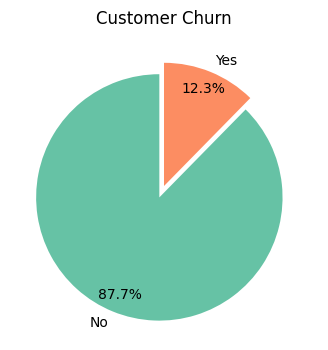

In [18]:
# Visualize customers that exited against customers that remained

plt.figure(figsize=(6,4))
exited_labels = loyalty_history['Exited'].value_counts().keys().tolist()
exited_values = loyalty_history['Exited'].value_counts().values.tolist()
colors = sns.color_palette('Set2')
explode = (0.1, 0)

# Create the pie chart
plt.pie(exited_values, labels=exited_labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
plt.title('Customer Churn')

plt.show()

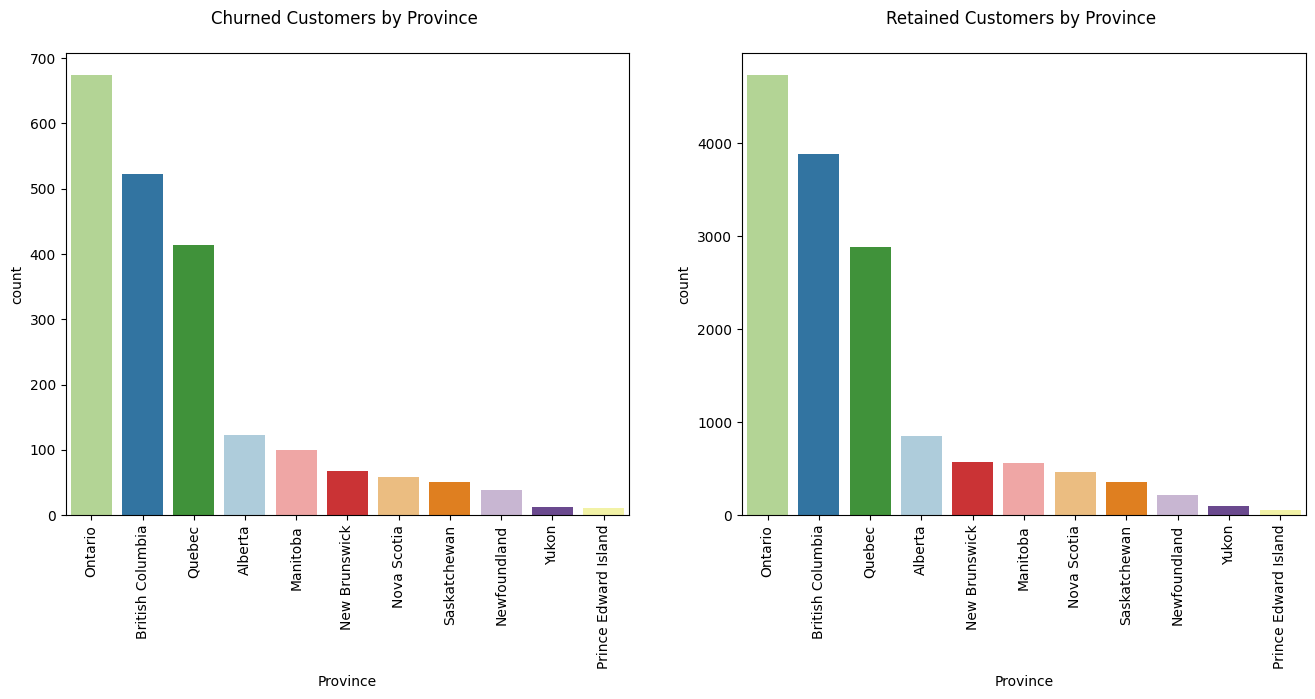

In [19]:
# Customer churn by province

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
province_order1 = loyalty_history[loyalty_history['Exited'] == 'Yes']['Province'].value_counts().index
province_order2 = loyalty_history[loyalty_history['Exited'] == 'No']['Province'].value_counts().index
colors = sns.color_palette("Paired")
province_colors = {'Alberta': colors[0], 'British Columbia': colors[1], 'Ontario': colors[2], 'Quebec': colors[3],
                  'Manitoba': colors[4], 'New Brunswick': colors[5], 'Nova Scotia': colors[6],'Saskatchewan': colors[7],
                  'Newfoundland': colors[8],'Yukon': colors[9],'Prince Edward Island': colors[10]}

ax1.set_title('Churned Customers by Province \n')
sns.countplot(x = 'Province', data = loyalty_history[loyalty_history['Exited']=='Yes'],
              hue='Province', palette=province_colors, order=province_order1, ax=ax1)
ax2.set_title('Retained Customers by Province \n')
sns.countplot(x = 'Province', data = loyalty_history[loyalty_history['Exited']=='No'],
              hue='Province', palette=province_colors, order=province_order2, ax=ax2)
ax1.tick_params('x', rotation=90)
ax2.tick_params('x', rotation=90)

plt.show()

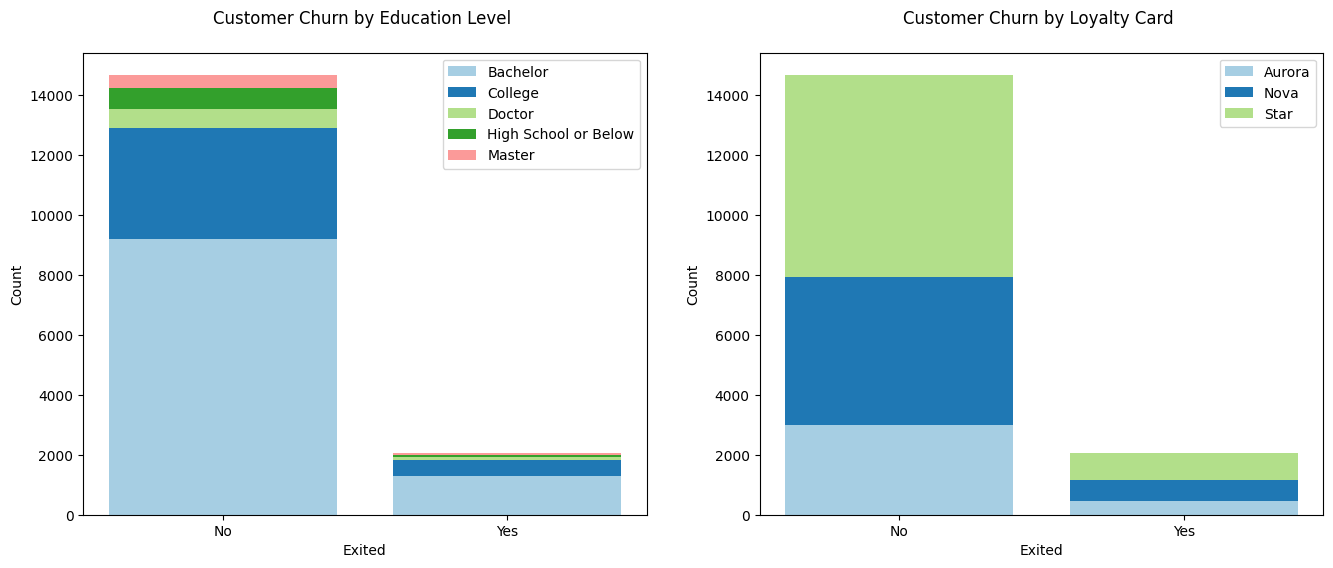

In [20]:
# Customer churn by education level and loyalty card

edu_grouped = loyalty_history.groupby(['Exited', 'Education']).size().unstack()
card_grouped = loyalty_history.groupby(['Exited', 'Loyalty Card']).size().unstack()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

bottom_values_edu = None
bottom_values_card = None
colors = sns.color_palette('Paired')

for education, color in zip(edu_grouped.columns, colors):
    ax1.bar(edu_grouped.index, edu_grouped[education], label=education, color=color, bottom=bottom_values_edu)
    bottom_values_edu = edu_grouped[education] if bottom_values_edu is None else bottom_values_edu + edu_grouped[education]

for card, color in zip(card_grouped.columns, colors):
    ax2.bar(card_grouped.index, card_grouped[card], label=card, color=color, bottom=bottom_values_card)
    bottom_values_card = card_grouped[card] if bottom_values_card is None else bottom_values_card + card_grouped[card]

ax1.set_title('Customer Churn by Education Level \n')
ax2.set_title('Customer Churn by Loyalty Card \n')
ax1.set_xlabel("Exited")
ax1.set_ylabel("Count")
ax2.set_xlabel("Exited")
ax2.set_ylabel("Count")
ax1.legend()
ax2.legend()

plt.show()

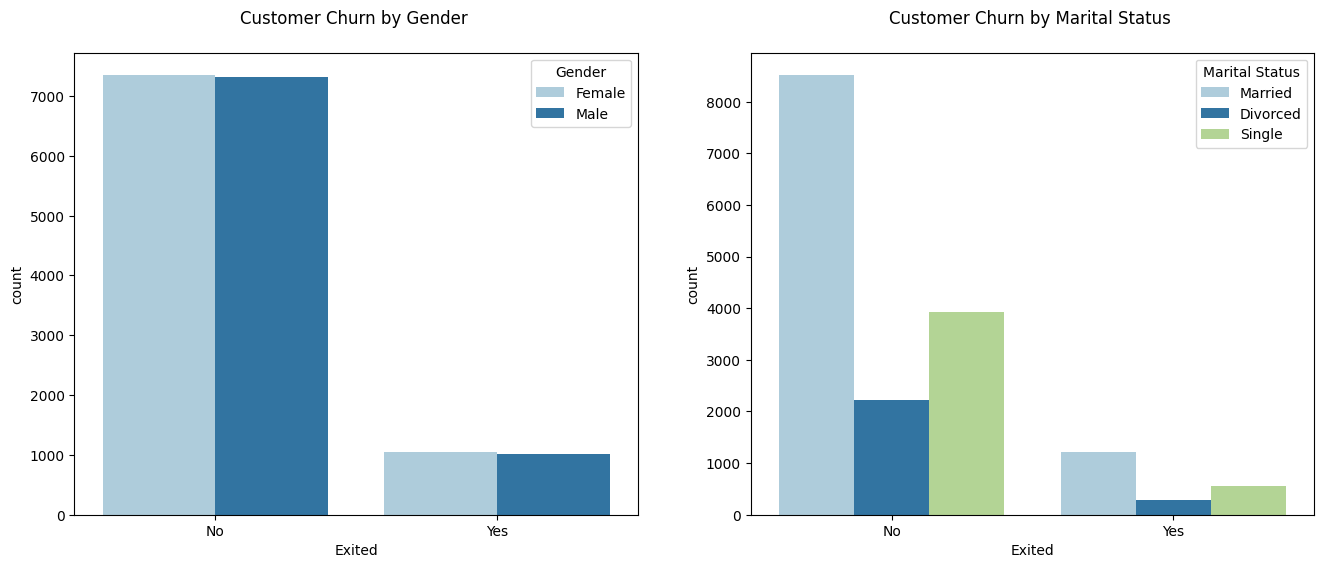

In [21]:
# Customer churn by gender and marital status

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

sns.countplot(x = 'Exited', data = loyalty_history, hue='Gender', palette='Paired', ax=ax1)
sns.countplot(x = 'Exited', data = loyalty_history, hue='Marital Status', palette='Paired', ax=ax2)
ax1.set_title('Customer Churn by Gender \n')
ax2.set_title('Customer Churn by Marital Status \n')

plt.show()

<Figure size 1200x600 with 0 Axes>

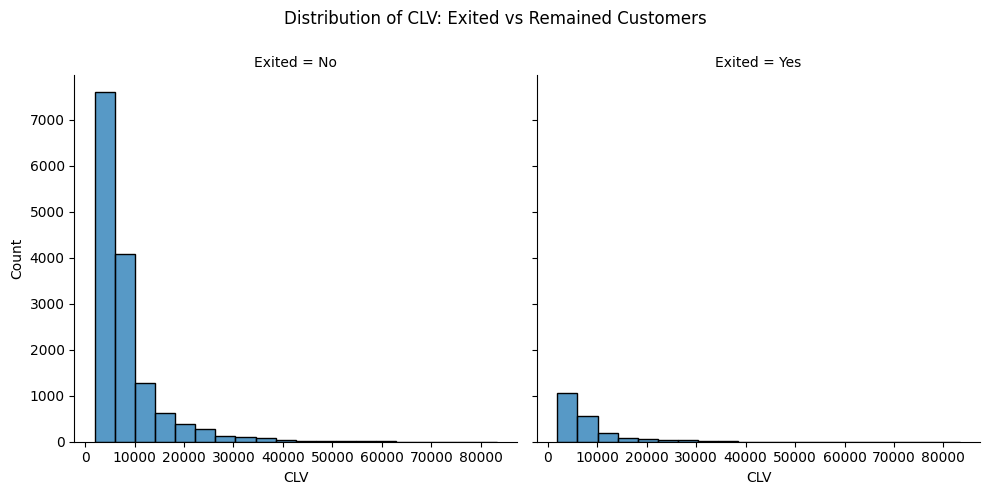

In [22]:
# Distribution of CLV in both exited and remained customers

plt.figure(figsize=(12,6))
g = sns.displot(data = loyalty_history, x = 'CLV', bins=20, col='Exited')
g.set_titles("Exited = {col_name}")
g.fig.suptitle("Distribution of CLV: Exited vs Remained Customers")
g.fig.subplots_adjust(top=0.85)

plt.show()

<Figure size 1200x600 with 0 Axes>

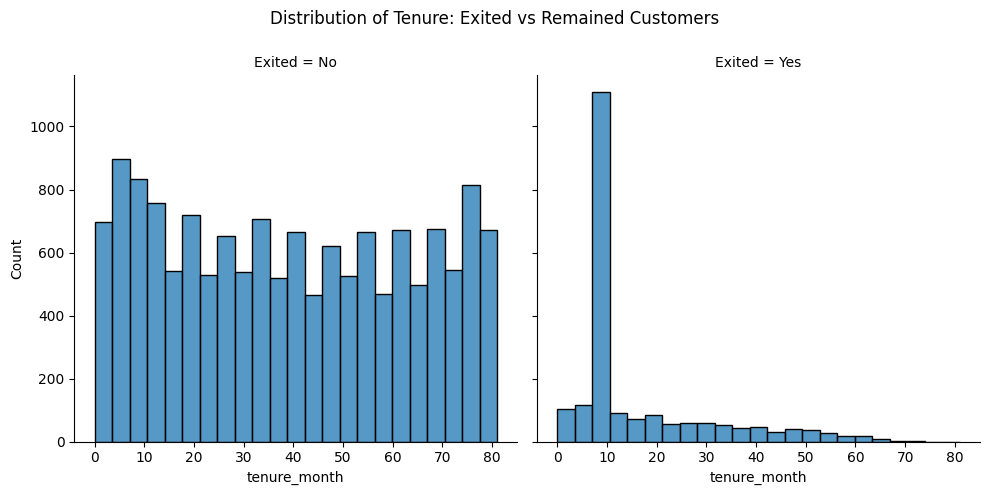

In [23]:
# Distribution of tenure in both exited and remained customers

plt.figure(figsize=(12,6))
g = sns.displot(data = loyalty_history, x = 'tenure_month', col='Exited')
g.set_titles("Exited = {col_name}")
g.fig.suptitle("Distribution of Tenure: Exited vs Remained Customers")
g.fig.subplots_adjust(top=0.85)

plt.show()

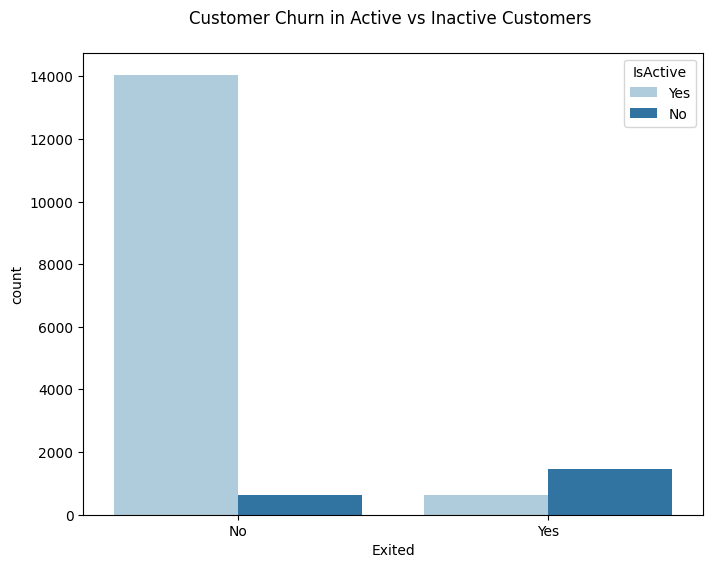

In [24]:
# Customer churn in active and non-active customers

plt.figure(figsize=(8,6))
sns.countplot(x = 'Exited', data = loyalty_history, hue='IsActive', palette='Paired')
plt.title('Customer Churn in Active vs Inactive Customers \n')

plt.show()

# ⚙️ Data Preprocessing

In [25]:
# Import necessary libraries

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [26]:
# Further enrich loyalty_history
# Add Flights Booked, Flights with Companions, Total Flights, Distance, Points Accumulated, Points Redeemed
# from cust_flight_point to loyalty_history

loyalty_history = loyalty_history.merge(cust_flight_point, on = 'Loyalty Number', how = 'left', suffixes = ('', ''))
loyalty_history.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Marital Status,Loyalty Card,CLV,...,tenure_month,flight_2018,IsActive,Exited,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,Married,Star,3839.14,...,35,88,Yes,No,132,39,171,51877,5224.44,1418
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,Divorced,Star,3839.61,...,34,108,Yes,No,190,25,215,41578,4176.04,1971
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,Single,Star,3839.75,...,42,6,Yes,Yes,66,21,87,19664,1963.00,374
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,Single,Star,3839.75,...,71,53,Yes,No,123,36,159,36043,3626.68,1291
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,Married,Star,3842.79,...,51,112,Yes,No,132,44,176,36840,3689.68,0


In [27]:
# Remove columns not needed

loyalty_history.drop(['Loyalty Number', 'Country', 'City', 'Postal Code', 'Enrollment Type', 'Enrollment Date',
                      'Cancellation Date', 'Enrollment Year', 'Enrollment Month', 'Cancellation Year',
                      'Cancellation Month', 'flight_2018'], axis = 'columns', inplace = True)
loyalty_history.head()

,Province,Gender,Education,Marital Status,Loyalty Card,CLV,tenure_month,IsActive,Exited,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed
0,Ontario,Female,Bachelor,Married,Star,3839.14,35,Yes,No,132,39,171,51877,5224.44,1418
1,Alberta,Male,College,Divorced,Star,3839.61,34,Yes,No,190,25,215,41578,4176.04,1971
2,British Columbia,Male,College,Single,Star,3839.75,42,Yes,Yes,66,21,87,19664,1963.00,374
3,Ontario,Male,College,Single,Star,3839.75,71,Yes,No,123,36,159,36043,3626.68,1291
4,Quebec,Male,Bachelor,Married,Star,3842.79,51,Yes,No,132,44,176,36840,3689.68,0


In [28]:
# Convert IsActive and Exited to binary integer form

loyalty_history['IsActive'] = loyalty_history['IsActive'].map({'Yes': 1, 'No': 0})
loyalty_history['Exited'] = loyalty_history['Exited'].map({'Yes': 1, 'No': 0})
loyalty_history.head()

,Province,Gender,Education,Marital Status,Loyalty Card,CLV,tenure_month,IsActive,Exited,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed
0,Ontario,Female,Bachelor,Married,Star,3839.14,35,1,0,132,39,171,51877,5224.44,1418
1,Alberta,Male,College,Divorced,Star,3839.61,34,1,0,190,25,215,41578,4176.04,1971
2,British Columbia,Male,College,Single,Star,3839.75,42,1,1,66,21,87,19664,1963.00,374
3,Ontario,Male,College,Single,Star,3839.75,71,1,0,123,36,159,36043,3626.68,1291
4,Quebec,Male,Bachelor,Married,Star,3842.79,51,1,0,132,44,176,36840,3689.68,0


In [29]:
# Encode nominal columns

nom_columns = ['Province', 'Gender', 'Marital Status']
loyalty_history = pd.get_dummies(loyalty_history, columns = nom_columns, drop_first = True, dtype = int)
loyalty_history.head()

,Education,Loyalty Card,CLV,tenure_month,IsActive,Exited,Flights Booked,Flights with Companions,Total Flights,Distance,...,Province_Newfoundland,Province_Nova Scotia,Province_Ontario,Province_Prince Edward Island,Province_Quebec,Province_Saskatchewan,Province_Yukon,Gender_Male,Marital Status_Married,Marital Status_Single
0,Bachelor,Star,3839.14,35,1,0,132,39,171,51877,...,0,0,1,0,0,0,0,0,1,0
1,College,Star,3839.61,34,1,0,190,25,215,41578,...,0,0,0,0,0,0,0,1,0,0
2,College,Star,3839.75,42,1,1,66,21,87,19664,...,0,0,0,0,0,0,0,1,0,1
3,College,Star,3839.75,71,1,0,123,36,159,36043,...,0,0,1,0,0,0,0,1,0,1
4,Bachelor,Star,3842.79,51,1,0,132,44,176,36840,...,0,0,0,0,1,0,0,1,1,0


In [30]:
# Encode ordinal columns

ord_columns = loyalty_history.select_dtypes(include=['object']).columns.tolist()
edu_order = ['High School or Below', 'College', 'Bachelor', 'Master', 'Doctor']
card_order = ['Star', 'Nova', 'Aurora']

encoder = OrdinalEncoder(categories = [edu_order, card_order])
encoded_values = encoder.fit_transform(loyalty_history[ord_columns])
encoded_values += 1
loyalty_history[['Education_encoded', 'LoyaltyCard_encoded']] = encoded_values.astype(int)

loyalty_history.head()

,Education,Loyalty Card,CLV,tenure_month,IsActive,Exited,Flights Booked,Flights with Companions,Total Flights,Distance,...,Province_Ontario,Province_Prince Edward Island,Province_Quebec,Province_Saskatchewan,Province_Yukon,Gender_Male,Marital Status_Married,Marital Status_Single,Education_encoded,LoyaltyCard_encoded
0,Bachelor,Star,3839.14,35,1,0,132,39,171,51877,...,1,0,0,0,0,0,1,0,3,1
1,College,Star,3839.61,34,1,0,190,25,215,41578,...,0,0,0,0,0,1,0,0,2,1
2,College,Star,3839.75,42,1,1,66,21,87,19664,...,0,0,0,0,0,1,0,1,2,1
3,College,Star,3839.75,71,1,0,123,36,159,36043,...,1,0,0,0,0,1,0,1,2,1
4,Bachelor,Star,3842.79,51,1,0,132,44,176,36840,...,0,0,1,0,0,1,1,0,3,1


In [31]:
# Drop original education and loyalty card columns

loyalty_history.drop(['Education', 'Loyalty Card'], axis = 'columns', inplace = True)
loyalty_history.head()

,CLV,tenure_month,IsActive,Exited,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,...,Province_Ontario,Province_Prince Edward Island,Province_Quebec,Province_Saskatchewan,Province_Yukon,Gender_Male,Marital Status_Married,Marital Status_Single,Education_encoded,LoyaltyCard_encoded
0,3839.14,35,1,0,132,39,171,51877,5224.44,1418,...,1,0,0,0,0,0,1,0,3,1
1,3839.61,34,1,0,190,25,215,41578,4176.04,1971,...,0,0,0,0,0,1,0,0,2,1
2,3839.75,42,1,1,66,21,87,19664,1963.00,374,...,0,0,0,0,0,1,0,1,2,1
3,3839.75,71,1,0,123,36,159,36043,3626.68,1291,...,1,0,0,0,0,1,0,1,2,1
4,3842.79,51,1,0,132,44,176,36840,3689.68,0,...,0,0,1,0,0,1,1,0,3,1


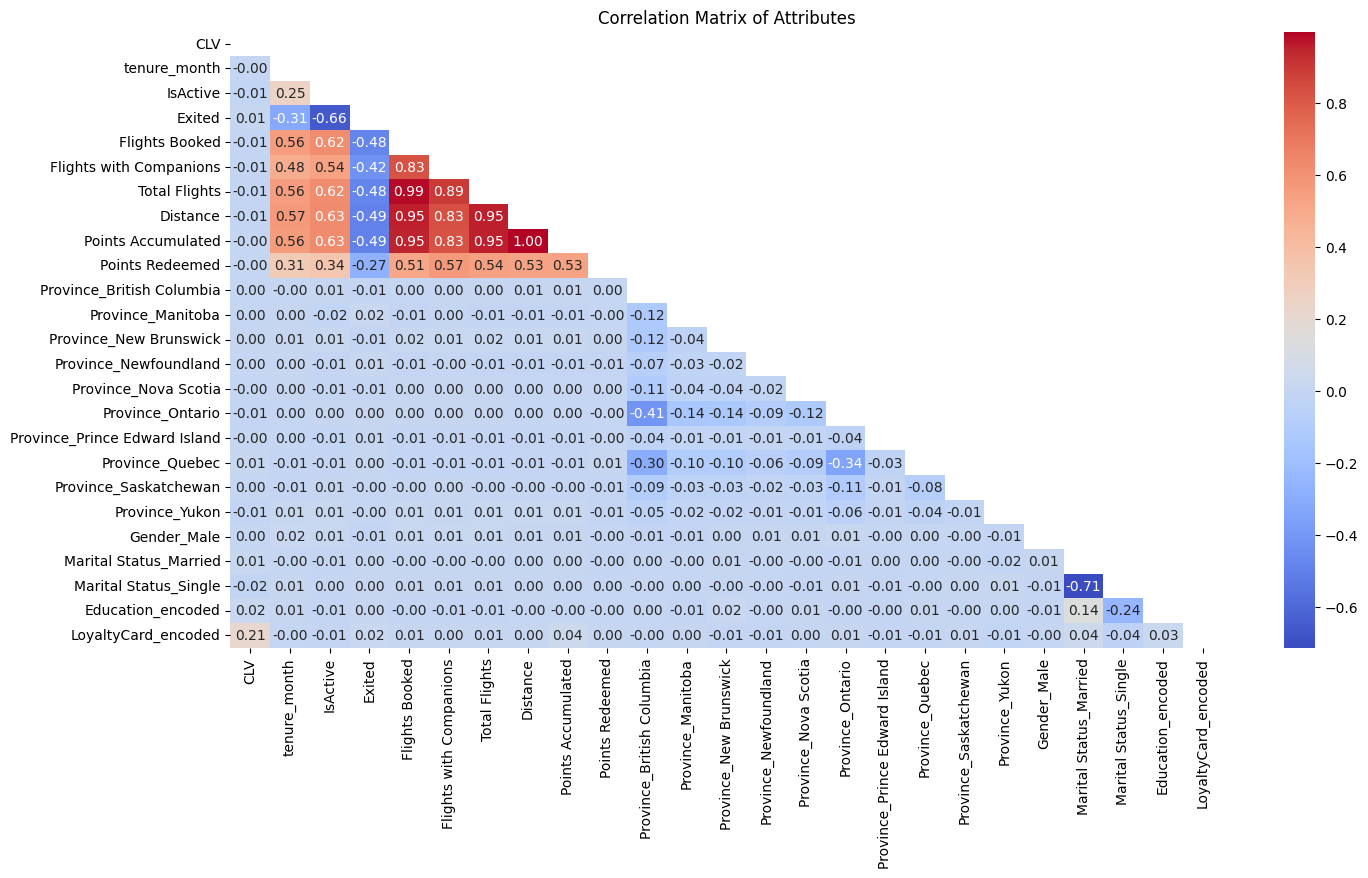

In [32]:
# Correlation between the attributes

correlation_matrix = loyalty_history.corr()

plt.figure(figsize=(16, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Attributes")

plt.show()

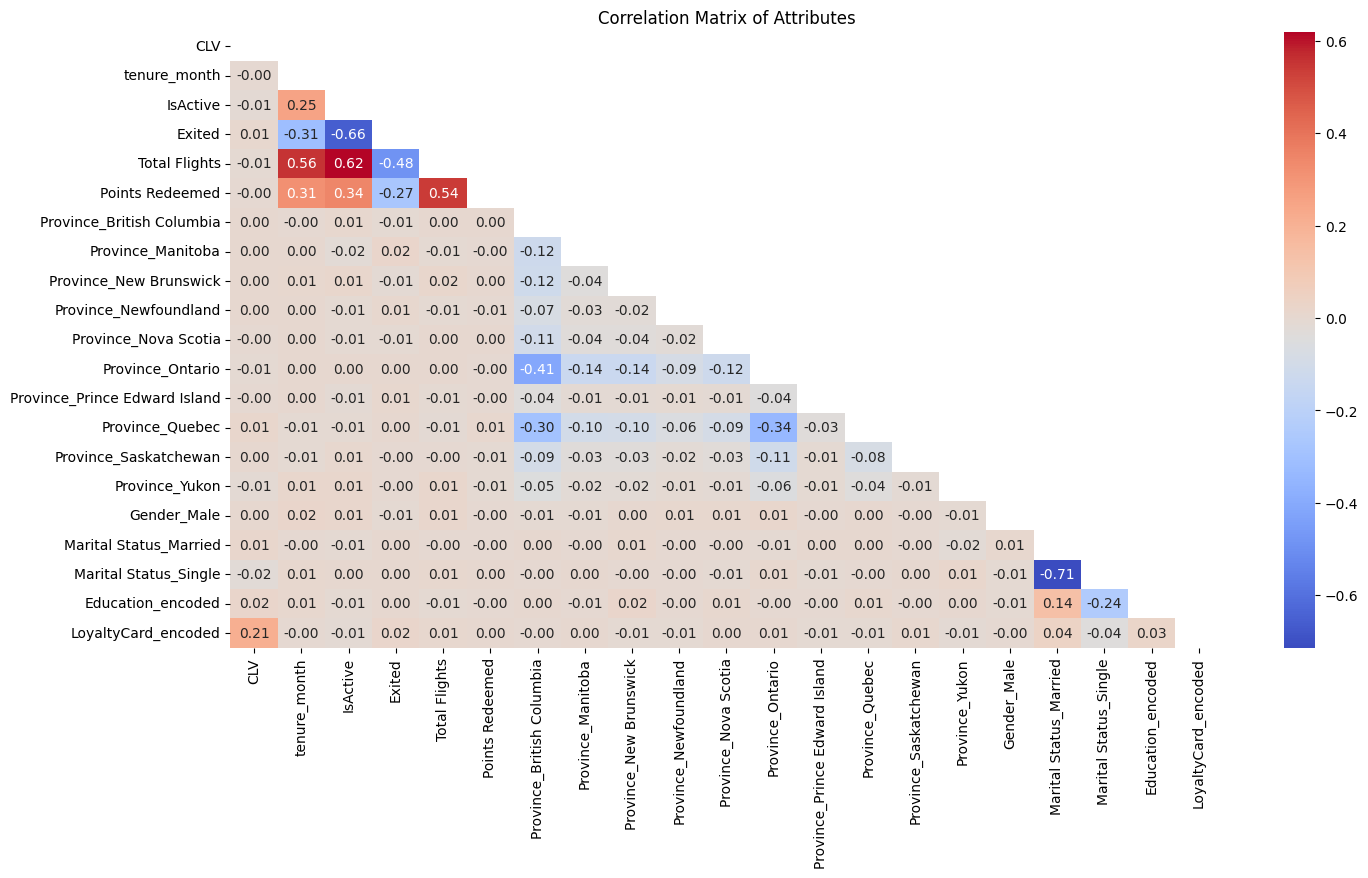

In [33]:
# Remove highly correlated attributes

loyalty_history.drop(['Distance', 'Points Accumulated', 'Flights Booked', 'Flights with Companions'], axis = 'columns', inplace = True)
correlation_matrix = loyalty_history.corr()

plt.figure(figsize=(16, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Attributes")

plt.show()

In [34]:
# Standardize attributes that require it

to_scale = ['CLV', 'tenure_month', 'Total Flights', 'Points Redeemed']
scaler = StandardScaler()
loyalty_history[to_scale] = scaler.fit_transform(loyalty_history[to_scale])
loyalty_history.head()

,CLV,tenure_month,IsActive,Exited,Total Flights,Points Redeemed,Province_British Columbia,Province_Manitoba,Province_New Brunswick,Province_Newfoundland,...,Province_Ontario,Province_Prince Edward Island,Province_Quebec,Province_Saskatchewan,Province_Yukon,Gender_Male,Marital Status_Married,Marital Status_Single,Education_encoded,LoyaltyCard_encoded
0,-0.604852,-0.054254,1,0,0.681447,0.937323,0,0,0,0,...,1,0,0,0,0,0,1,0,3,1
1,-0.604784,-0.095095,1,0,1.329532,1.706309,0,0,0,0,...,0,0,0,0,0,1,0,0,2,1
2,-0.604763,0.231632,1,1,-0.555806,-0.514433,1,0,0,0,...,0,0,0,0,0,1,0,1,2,1
3,-0.604763,1.416016,1,0,0.504697,0.760720,0,0,0,0,...,1,0,0,0,0,1,0,1,2,1
4,-0.604320,0.599199,1,0,0.755093,-1.034507,0,0,0,0,...,0,0,1,0,0,1,1,0,3,1


In [35]:
# Split the dataset into training and testing sets (80% train, 20% test)

X = loyalty_history.drop(['Exited'], axis = 'columns')
y = loyalty_history['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [36]:
# Target variable (Exited) has class imbalance 12.3% churned customers against 87.7% customers that remained
# Use SMOTE to balance the class distribution

X_train_init = X_train.copy()
y_train_init = y_train.copy()

smote = SMOTE(random_state = 123)
X_train, y_train = smote.fit_resample(X_train, y_train)

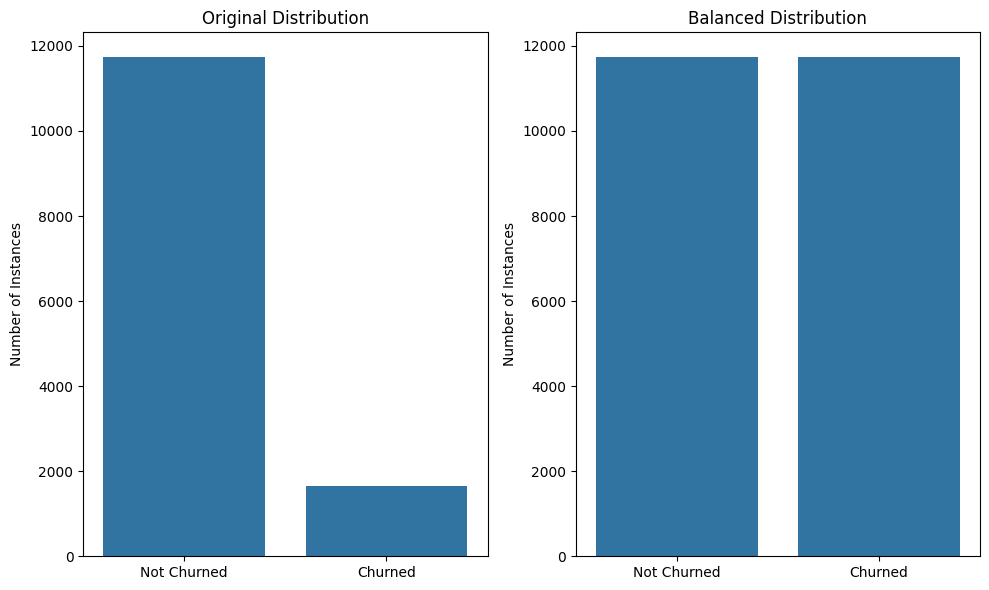

In [37]:
# Visulaize the result of SMOTE balancing class distribution

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

unique, counts = np.unique(y_train_init, return_counts=True)
sns.barplot(x = unique, y = counts, ax = ax1)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Not Churned', 'Churned'])
ax1.set_ylabel('Number of Instances')
ax1.set_title('Original Distribution')

unique2, counts2 = np.unique(y_train, return_counts=True)
sns.barplot(x = unique2, y = counts2, ax = ax2)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Not Churned', 'Churned'])
ax2.set_ylabel('Number of Instances')
ax2.set_title('Balanced Distribution')
plt.tight_layout()

plt.show()

# 🎯 Model Evaluation

I obtained better results from manually tuning the models as against using RandomizedSearchCV or GridSearchCV. Manual tuning is used for all models.

### K-Nearest Neighbors (KNN)

In [38]:
from sklearn.neighbors import KNeighborsClassifier

def knn_tuning_uniform(k):
  classifier = KNeighborsClassifier(n_neighbors = k, weights = 'uniform')
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

def knn_tuning_distance(k):
  classifier = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

In [39]:
# Tuning the model

knn_results = pd.DataFrame({'K':np.arange(1, 101, 5)})

knn_results['Uniform'] = knn_results['K'].apply(knn_tuning_uniform)
knn_results['Distance'] = knn_results['K'].apply(knn_tuning_distance)

knn_results

# Optimal is k = 6, weights = 'uniform'

,K,Uniform,Distance
0,1,0.870968,0.870968
1,6,0.873955,0.860215
2,11,0.856930,0.862903
3,16,0.868877,0.867682
4,21,0.854839,0.862306
5,26,0.862306,0.862007
6,31,0.852748,0.861111
7,36,0.859618,0.863501
8,41,0.854241,0.863202
9,46,0.856631,0.864397


In [40]:
# Accuracy and classification report of optimal parameters from model tuning

classifier = KNeighborsClassifier(n_neighbors = 6, weights = 'uniform')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy of KNN: {accuracy} \n")
classification = classification_report(y_test, y_pred)
print(f"Classification Report of KNN: \n {classification}")

Accuracy of KNN: 0.8739545997610514 

Classification Report of KNN: 
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      2938
           1       0.49      0.77      0.60       410

    accuracy                           0.87      3348
   macro avg       0.73      0.83      0.76      3348
weighted avg       0.91      0.87      0.89      3348



### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

def tree_depth_tuning_entropy(d):
  classifier = RandomForestClassifier(criterion = 'entropy', max_depth=d, random_state = 123)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

def tree_depth_tuning_gini(d):
  classifier = RandomForestClassifier(criterion = 'gini', max_depth=d, random_state = 123)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

def tree_depth_tuning_log_loss(d):
  classifier = RandomForestClassifier(criterion = 'log_loss', max_depth=d, random_state = 123)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

In [42]:
# Tuning the model

rforest_result = pd.DataFrame({'D':np.arange(1, 20)})

rforest_result['entropy_accuracy'] = rforest_result['D'].apply(tree_depth_tuning_entropy)
rforest_result['gini_accuracy'] = rforest_result['D'].apply(tree_depth_tuning_gini)
rforest_result['log_loss_accuracy'] = rforest_result['D'].apply(tree_depth_tuning_log_loss)

rforest_result

# Optimal max_depth = 18, criterion = 'gini'

,D,entropy_accuracy,gini_accuracy,log_loss_accuracy
0,1,0.853644,0.855137,0.853644
1,2,0.856930,0.851553,0.856930
2,3,0.847969,0.845878,0.847969
3,4,0.898447,0.883214,0.898447
4,5,0.914576,0.916667,0.914576
5,6,0.944146,0.935484,0.944146
6,7,0.945639,0.941458,0.945639
7,8,0.948327,0.947133,0.948327
8,9,0.948925,0.949223,0.948925
9,10,0.948626,0.949223,0.948626


In [43]:
# Accuracy and classification report of optimal parameters from model tuning

classifier = RandomForestClassifier(criterion = 'gini', max_depth = 18, random_state = 123)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy of Random Forest: {accuracy} \n")
classification = classification_report(y_test, y_pred)
print(f"Classification Report of Random Forest: \n {classification}")

Accuracy of Random Forest: 0.956989247311828 

Classification Report of Random Forest: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      2938
           1       0.83      0.82      0.82       410

    accuracy                           0.96      3348
   macro avg       0.90      0.90      0.90      3348
weighted avg       0.96      0.96      0.96      3348



### Support Vector Classification (SVC)

In [44]:
from sklearn import svm

def svc_tuning_rbf(C):
  classifier = svm.SVC(C = C, kernel='rbf', random_state = 123)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

def svc_tuning_linear(C):
  classifier = svm.SVC(C = C, kernel='linear', random_state = 123)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

def svc_tuning_poly(C):
  classifier = svm.SVC(C = C, kernel='poly', random_state = 123)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

In [45]:
# Tuning the model

svc_results = pd.DataFrame({'C':[0.01, 0.1, 1, 10, 100]})

svc_results['rbf_accuracy'] = svc_results['C'].apply(svc_tuning_rbf)
#svc_results['linear_accuracy'] = svc_results['C'].apply(svc_tuning_linear)
svc_results['poly_accuracy'] = svc_results['C'].apply(svc_tuning_poly)

svc_results

# Optimal is C = 0.1, kernel='rbf'

,C,rbf_accuracy,poly_accuracy
0,0.01,0.855735,0.857826
1,0.10,0.942354,0.940860
2,1.00,0.933692,0.928017
3,10.00,0.916069,0.920251
4,100.00,0.901434,0.907109


In [46]:
# Accuracy and classification report of optimal parameters from model tuning

classifier = svm.SVC(C = 0.1, kernel='rbf', random_state = 123)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy of SVC: {accuracy} \n")
classification = classification_report(y_test, y_pred)
print(f"Classification Report of SVC: \n {classification}")

Accuracy of SVC: 0.9423536439665472 

Classification Report of SVC: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      2938
           1       0.79      0.72      0.75       410

    accuracy                           0.94      3348
   macro avg       0.88      0.85      0.86      3348
weighted avg       0.94      0.94      0.94      3348



### Naive Bayes

In [47]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy of Gaussian NB: {accuracy} \n")
classification = classification_report(y_test, y_pred)
print(f"Classification Report of Gaussian NB: \n {classification}")

Accuracy of Gaussian NB: 0.7962962962962963 

Classification Report of Gaussian NB: 
               precision    recall  f1-score   support

           0       0.98      0.79      0.87      2938
           1       0.36      0.87      0.51       410

    accuracy                           0.80      3348
   macro avg       0.67      0.83      0.69      3348
weighted avg       0.90      0.80      0.83      3348



### Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression

def logistic_tuning_lbfgs(C):
  classifier = LogisticRegression(C = C, solver = 'lbfgs', random_state = 123)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

def logistic_tuning_liblinear(C):
  classifier = LogisticRegression(C = C, solver = 'liblinear', random_state = 123)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

def logistic_tuning_sag(C):
  classifier = LogisticRegression(C = C, solver = 'sag', random_state = 123)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

def logistic_tuning_saga(C):
  classifier = LogisticRegression(C = C, solver = 'saga', random_state = 123)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  return accuracy

In [49]:
# Tuning the model

logistic_results = pd.DataFrame({'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

logistic_results['lbfgs_accuracy'] = logistic_results['C'].apply(logistic_tuning_lbfgs)
logistic_results['liblinear_accuracy'] = logistic_results['C'].apply(logistic_tuning_liblinear)
logistic_results['sag_accuracy'] = logistic_results['C'].apply(logistic_tuning_sag)
logistic_results['saga_accuracy'] = logistic_results['C'].apply(logistic_tuning_saga)

logistic_results

# sag and saga solver seem to produce same result
# Optimal C = 1.0, solver = 'sag' or 'saga'

,C,lbfgs_accuracy,liblinear_accuracy,sag_accuracy,saga_accuracy
0,0.001,0.825568,0.825568,0.825866,0.825866
1,0.010,0.853345,0.851254,0.853345,0.853345
2,0.100,0.876643,0.870968,0.876941,0.876941
3,1.000,0.879032,0.877838,0.879331,0.879331
4,10.000,0.878734,0.878734,0.878734,0.878734
5,100.000,0.878435,0.878734,0.878734,0.878734
6,1000.000,0.878734,0.878734,0.879032,0.879032


In [50]:
# Accuracy and classification report of optimal parameters from model tuning

classifier = LogisticRegression(C = 1, solver = 'sag', random_state = 123)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy of Logistic Regression with Solver as 'sag': {accuracy} \n")
classification = classification_report(y_test, y_pred)
print(f"Classification Report of Logistic Regression with Solver as 'sag': \n {classification}")

Accuracy of Logistic Regression with Solver as 'sag': 0.8793309438470729 

Classification Report of Logistic Regression with Solver as 'sag': 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      2938
           1       0.50      0.75      0.60       410

    accuracy                           0.88      3348
   macro avg       0.73      0.83      0.77      3348
weighted avg       0.91      0.88      0.89      3348



In [51]:
classifier = LogisticRegression(C = 1, solver = 'saga', random_state = 123)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy of Logistic Regression with Solver as 'saga': {accuracy} \n")
classification = classification_report(y_test, y_pred)
print(f"Classification Report of Logistic Regression with Solver as 'saga': \n {classification}")

Accuracy of Logistic Regression with Solver as 'saga': 0.8793309438470729 

Classification Report of Logistic Regression with Solver as 'saga': 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      2938
           1       0.50      0.75      0.60       410

    accuracy                           0.88      3348
   macro avg       0.73      0.83      0.77      3348
weighted avg       0.91      0.88      0.89      3348



# 🚀 Final Model

- **KNN:** Optimal tuning is `n_neighbors = 6`, `weights = 'uniform'`. Highest accuracy is **0.873955**.
- **Random Forest:** Optimal tuning is `max_depth = 18`, `criterion = 'gini'`. Highest accuracy is **0.956989**.
- **SVC:** Optimal tuning is `kernel='rbf'`, `C = 0.1`. Highest accuracy is **0.942354**.
- **Gaussian NB:** Accuracy is **0.796296**.
- **Logistic Regression:** Optimal tuning is `C = 1.0`, `solver = 'sag'`. Highest accuracy is **0.879331**.


In [52]:
# Use esemble learning technique VotingClassifier to make the final prediction
# Not use Gaussian NB as accuracy < 0.8
# Removed svm.SVC() from soft voting models as probability is set to false in this model
# Enabling probability will slow dowm svm.SVC()

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

models_hard = [
    ('KNN', KNeighborsClassifier(n_neighbors = 6, weights = 'uniform')),
    ('RF', RandomForestClassifier(criterion = 'gini', max_depth = 18, random_state = 123)),
    ('SVM', svm.SVC(kernel ='rbf', C = 0.1, random_state = 123)),
    ('LR', LogisticRegression(C = 1, solver = 'sag', random_state = 123))
]

models_soft = [
    ('KNN', KNeighborsClassifier(n_neighbors = 6, weights = 'uniform')),
    ('RF', RandomForestClassifier(criterion = 'gini', max_depth = 18, random_state = 123)),
    ('LR', LogisticRegression(C = 1, solver = 'sag', random_state = 123))
]

vote_hard = VotingClassifier(estimators=models_hard, voting='hard')
score_hard = cross_val_score(vote_hard, X_train, y_train, cv=10)
print('Hard voting score: ', score_hard)
print('Hard voting mean score: ', score_hard.mean(), '\n')

vote_soft = VotingClassifier(estimators=models_soft, voting='soft')
score_soft = cross_val_score(vote_soft, X_train, y_train, cv=10)
print('Soft voting score: ', score_soft)
print('Soft voting mean score: ', score_soft.mean())

Hard voting score:  [0.85087346 0.86962079 0.8853856  0.89092458 0.88405797 0.8887468
 0.90110827 0.88192668 0.89855072 0.88746803]
Hard voting mean score:  0.8838662913712195 

Soft voting score:  [0.91095015 0.93182787 0.9488709  0.94162761 0.93393009 0.94117647
 0.94714408 0.94117647 0.94543905 0.94501279]
Soft voting mean score:  0.9387155466102634


In [53]:
# Accuracy for both hard and soft voting

vote_hard.fit(X_train, y_train)
y_pred_hard = vote_hard.predict(X_test)
score_hard = accuracy_score(y_test, y_pred_hard)

vote_soft.fit(X_train, y_train)
y_pred_soft = vote_soft.predict(X_test)
score_soft = accuracy_score(y_test, y_pred_soft)

print('Hard Voting Accuracy: ', score_hard)
print('Soft Voting Accuracy: ', score_soft)

Hard Voting Accuracy:  0.945041816009558
Soft Voting Accuracy:  0.9277180406212664


In [54]:
# Classification report for both hard and soft voting

print('Hard Voting Classification Report: \n', classification_report(y_test, y_pred_hard))
print('Soft Voting Classification Report: \n', classification_report(y_test, y_pred_soft))


Hard Voting Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      2938
           1       0.80      0.73      0.76       410

    accuracy                           0.95      3348
   macro avg       0.88      0.85      0.87      3348
weighted avg       0.94      0.95      0.94      3348

Soft Voting Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      2938
           1       0.67      0.81      0.73       410

    accuracy                           0.93      3348
   macro avg       0.82      0.88      0.85      3348
weighted avg       0.94      0.93      0.93      3348



In [55]:
# Confusion matrix for both hard and soft voting

print('Hard Voting Confusion Matrix: \n', confusion_matrix(y_test, y_pred_hard), '\n')
print('Soft Voting Confusion Matrix: \n', confusion_matrix(y_test, y_pred_soft))

Hard Voting Confusion Matrix: 
 [[2865   73]
 [ 111  299]] 

Soft Voting Confusion Matrix: 
 [[2775  163]
 [  79  331]]


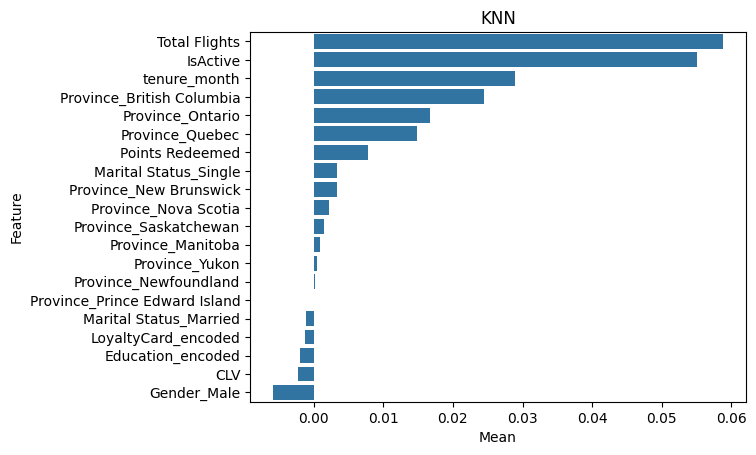

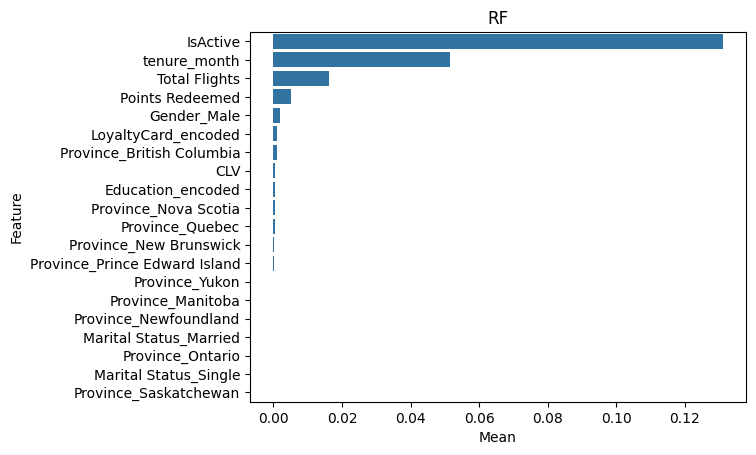

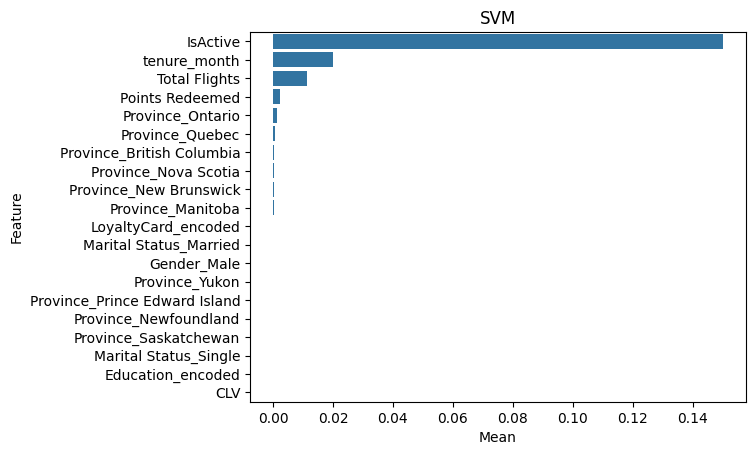

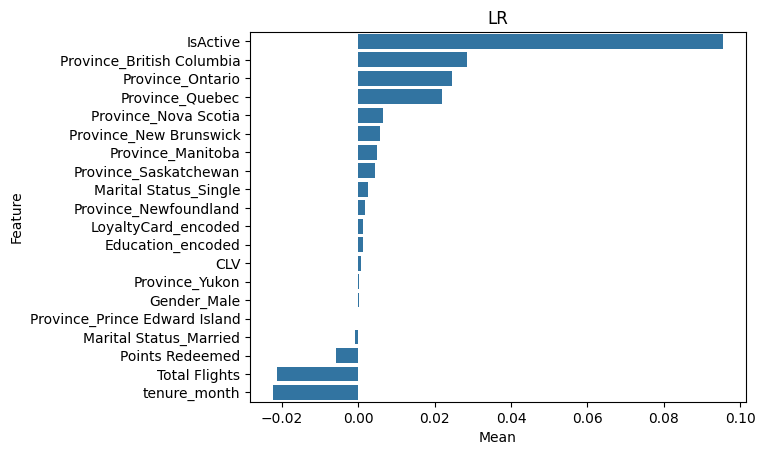

In [56]:
# Feature importance from all selected models using permutation_importance

models_hard = [
    ('KNN', KNeighborsClassifier(n_neighbors = 6, weights = 'uniform')),
    ('RF', RandomForestClassifier(criterion = 'gini', max_depth = 18, random_state = 123)),
    ('SVM', svm.SVC(kernel ='rbf', C = 0.1, random_state = 123)),
    ('LR', LogisticRegression(C = 1, solver = 'sag', random_state = 123))
]

for name, model in models_hard:
        md = model.fit(X_train, y_train)
        result = permutation_importance(md, X_test, y_test, n_repeats=10,random_state=123)
        feature_imp = pd.Series(result.importances_mean,
                        index=X.columns).sort_values(ascending=False)

        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Mean')
        plt.ylabel('Feature')
        plt.title(name)

        plt.show()

## 📊 Summary & Key Takeaways

This project demonstrated how **machine learning can help airlines predict customer churn and uncover the key factors driving it**. The project journey covered several essential steps, including:

- **Data Import and Cleaning:** Merged and cleaned two customer datasets — one detailing loyalty program histories and the other tracking flight activity.

- **Exploratory Data Analysis (EDA):** Uncovered trends and patterns in customer behavior, demography, flight activity, and loyalty program engagement.

- **Feature Engineering:** Created meaningful features such as tenure, total flights, points earned, and activity status to better capture customer behavior. Also transformed categorical features into a numerical representation, scaled numerical variables to have a similar scale, and addressed class imbalance in the target variable.

- **Model Building and Evaluation:** Implemented supervised machine learning classification models to predict churn, evaluated model performance using appropriate metrics, and selected the most suitable models in the ensemble model for deployment.

- **Insights Extraction:** Identified top factors contributing to customer churn, providing valuable business insights for targeted retention campaigns, service enhancements, and customer loyalty initiatives.

**Key Takeaway:**  
Machine learning offers a powerful, data-driven approach for predicting customer churn and uncovering the reasons behind customer attrition. With these insights, airlines can take proactive, informed steps to reduce churn rates, improve customer satisfaction, and optimize operational strategies.

This project highlights how blending business understanding with predictive analytics can lead to smarter decision-making.
